Using SPEXone and OCI data for analyzing the impact of dust plumes on marine organism

SETUP <br>
Load necessary packages and auth to cryocloud

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from dask.distributed import Client

In [2]:
client = Client()
auth = earthaccess.login("../login.netrc")

SETUP: LOAD <br>
Specifying parameter for loading the data

In [3]:
# --- TIME ---

tspan = ("2024-07-01 00:00", "2024-07-01 06:00")

# --- REGION ---

region = (-60, 0, 5, 20)
region = (-180, -90, 180, 90)
#region =  (-20, 10,  -8, 30) #WSEN

SETUP: TARGET GRID <br>
Parameters for interpolating swath data into a common grid

In [4]:
# --- TARGET GRID ---
res = 1.0

tgt_lat = np.arange(region[1] + res/2, region[3], res)
tgt_lon = np.arange(region[0] + res/2, region[2], res)

# --- INTERPOLATION METHOD ---
method='linear'

In [5]:
# --- TIME (3-hour steps) ---
times = pd.date_range(start=tspan[0], end=tspan[1], freq="3H")

# --- EMPTY TEMPLATE ARRAY (filled with NaNs) ---
diff = xr.DataArray(
    data=np.full((times.size, tgt_lat.size, tgt_lon.size), np.nan, dtype="float32"),
    dims=("time", "latitude", "longitude"),
    coords={"time": times, "latitude": tgt_lat, "longitude": tgt_lon},
    name="diff"
)

# (Optional) nice metadata
diff.attrs.update({
    "long_name": "3-hour mean difference (OCI - SPX)",
    "description": f"Template on {res}° grid for {tspan[0]} to {tspan[1]}",
})
diff["latitude"].attrs.update({"standard_name": "latitude", "units": "degrees_north"})
diff["longitude"].attrs.update({"standard_name": "longitude", "units": "degrees_east"})

FUNCTIONS <br>
Helpers to interpolate the data

In [6]:
def time_from_attr(ds):
    """
    Set the start time attribute as a dataset variable.

    Parameters
    ----------
    ds a dataset corresponding to a Level-2 granule
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["time"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("time")
    return ds

def grid_match(path, instr="OCI"):
    """
    Interpolate swath data to common grid

    Parameters
    ----------
    path to the dataset 
    instr the instrument for 
    """
    from rasterio.warp import Resampling

    # specifiy according to instr
    var = "chlor_a"
    geoloc_group = "navigation_data"
    if instr == "SPX":
        var = "chla"
        geoloc_group = "geolocation_data"

    # open dataset
    with xr.open_datatree(path) as dt:
        # Source data & geolocation
        da  = dt["geophysical_data"][var]
        lon = dt[geoloc_group]["longitude"]
        lat = dt[geoloc_group]["latitude"]

        da = da.rio.set_spatial_dims("pixels_per_line", "number_of_lines")        
        da = da.rio.set_crs("epsg:4326")

        # reproject the data to gridded lon-lat data
        da_out = da.rio.reproject(
            dst_crs='EPSG:4326',
            src_geoloc_array=(
                lon.values,
                lat.values,
            ),
            resampling=Resampling.nearest
        )
        # rename the dimensions
        da_out = da_out.rename({"x": "longitude", "y": "latitude"})
        
        # interpolate to common grid
        da_out = da_out.interp(latitude=tgt_lat, longitude=tgt_lon, method="linear", kwargs={"fill_value": np.nan})
        return da_out


CALCULATE IN 3H STEPS

In [7]:
# Generate 3H steps including start and end
time_bins = pd.date_range(start=tspan[0], end=tspan[1], freq="3H")

for t0, t1 in zip(time_bins[:-1], time_bins[1:]):

    print("Interval:", t0, "→", t1)
    
    tspan_step = (t0.strftime("%Y-%m-%d %H:%M"), t1.strftime("%Y-%m-%d %H:%M"))
    
    # --- OCI ---

    results = earthaccess.search_data(
        short_name="PACE_OCI_L2_BGC",
        temporal=tspan_step,
        bounding_box=region
    )
    paths = earthaccess.open(results)
    kwargs = {"combine": "nested", "concat_dim": "time", "decode_timedelta" : True}

    attrs = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)

    futures = client.map(
        grid_match,
        paths,
    )

    chla_OCI = xr.combine_nested(client.gather(futures), concat_dim="time")
    chla_OCI["time"] = attrs["time"]
    chla_OCI_3h = chla_OCI.resample(time="3H").mean()

    # --- SPEXone ---

    results = earthaccess.search_data(
        short_name="PACE_SPEXONE_L2_AER_RTAPOCEAN",
        temporal=tspan_step,
        bounding_box=region
    )
    paths = earthaccess.open(results)

    attrs = xr.open_mfdataset(paths, preprocess=time_from_attr, **kwargs)

    futures = client.map(
        grid_match,
        paths,
        instr="SPX"
    )

    chla_SPX = xr.combine_nested(client.gather(futures), concat_dim="time")
    chla_SPX["time"] = attrs["time"]
    chla_SPX_3h = chla_SPX.resample(time="3H").mean()

    # Compute resampled difference (keeps the time dimension)
    resampled = chla_OCI_3h - chla_SPX_3h

    # Take second time step if available, otherwise fallback to first
    if resampled.sizes["time"] > 1:
        field = resampled.isel(time=1)
    else:
        field = resampled.isel(time=0)

    # Assign it into diff at the first time step
    diff.loc[dict(time=diff.time[0])] = field

Interval: 2024-07-01 00:00:00 → 2024-07-01 03:00:00


QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10 [00:00<?, ?it/s]

Interval: 2024-07-01 03:00:00 → 2024-07-01 06:00:00


QUEUEING TASKS | :   0%|          | 0/18 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/18 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/18 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/11 [00:00<?, ?it/s]

PLOT

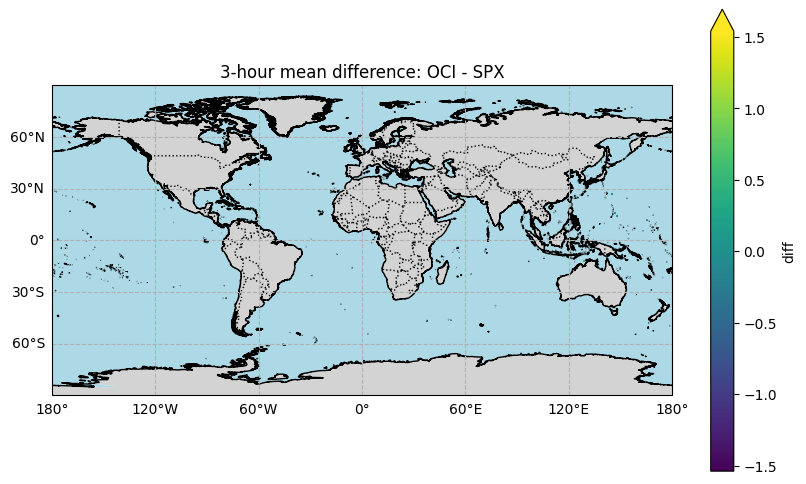

In [11]:

# Set up plot with projection
fig, ax = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(10, 6)
)

# Plot data
im = diff.mean('time').plot.imshow(
    ax=ax,
    transform=ccrs.PlateCarree(),  # needed so data is placed correctly
    robust=True,
    cmap="viridis"                 # choose colormap if you like
)

# Add coastlines and features
ax.coastlines(resolution="10m", color="black", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--")
gl.top_labels = False
gl.right_labels = False

plt.title("3-hour mean difference: OCI - SPX")
plt.show()

In [12]:
diff.mean()

<xarray.DataArray 'diff' ()> Size: 4B
array(0.34570727, dtype=float32)